In [1]:
!pip install annoy scikit-learn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552448 sha256=50c0d23fbc38deb84956ea9dfb6158f37fcb649a5520f031d76b53df8e20ef45
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [2]:
from annoy import AnnoyIndex
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
from tabulate import tabulate
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

In [ ]:
# Bước 1: Đọc và làm sạch dữ liệu
df = pd.read_csv('dataset.csv')

In [ ]:
df = df.fillna('')

In [ ]:
df

,product_id,product_name,category,sub_category,item,about_product,price,rating,rating_count
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,Accessories&Peripherals,USBCables,High Compatibility : Compatible With iPhone 12...,1099.0,4.2,24269.0
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories,Accessories&Peripherals,USBCables,"Compatible with all Type C enabled devices, be...",349.0,4.0,43994.0
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories,Accessories&Peripherals,USBCables,【 Fast Charger& Data Sync】-With built-in safet...,1899.0,3.9,7928.0
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories,Accessories&Peripherals,USBCables,The boAt Deuce USB 300 2 in 1 cable is compati...,699.0,4.2,94363.0
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories,Accessories&Peripherals,USBCables,[CHARGE & SYNC FUNCTION]- This cable comes wit...,399.0,4.2,16905.0
...,...,...,...,...,...,...,...,...,...
1381,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,Home&Kitchen,Kitchen&HomeAppliances,WaterPurifierAccessories,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,919.0,4.0,1090.0
1382,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,Home&Kitchen,Kitchen&HomeAppliances,Rice&PastaCookers,"230 Volts, 400 watts, 1 Year",3045.0,4.1,4118.0
1383,B009P2LIL4,Bajaj Majesty RX10 2000 Watts Heat Convector R...,Home&Kitchen,"Heating,Cooling&AirQuality",HeatConvectors,International design and styling|Two heat sett...,3080.0,3.6,468.0
1384,B00J5DYCCA,Havells Ventil Air DSP 230mm Exhaust Fan (Pist...,Home&Kitchen,"Heating,Cooling&AirQuality",ExhaustFans,Fan sweep area: 230 MM ; Noise level: (40 - 45...,1890.0,4.0,8031.0


In [ ]:
# Bước 2: Chuyển đổi dữ liệu dạng văn bản thành vector số
tfidf_name = TfidfVectorizer()
tfidf_matrix_name = tfidf_name.fit_transform(df['product_name'])

tfidf_category = TfidfVectorizer()
tfidf_matrix_category = tfidf_category.fit_transform(df['category'])

tfidf_sub_category = TfidfVectorizer()
tfidf_matrix_sub_category = tfidf_sub_category.fit_transform(df['sub_category'])

tfidf_item = TfidfVectorizer()
tfidf_matrix_item = tfidf_item.fit_transform(df['item'])

tfidf_description = TfidfVectorizer()
tfidf_matrix_description = tfidf_description.fit_transform(df['about_product'])

In [ ]:
# Bước 3: Chuẩn hóa dữ liệu số
numerical_features = df[['price']].values
scaler = MinMaxScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features)

In [ ]:
# Bước 4: Kết hợp tất cả các vector đặc trưng
product_features = np.hstack([tfidf_matrix_name.toarray(),
                   tfidf_matrix_category.toarray(),
                   tfidf_matrix_sub_category.toarray(),
                   tfidf_matrix_item.toarray(),
                   tfidf_matrix_description.toarray(),
                   numerical_features_scaled.reshape(-1, 1)])

# Chuẩn hóa product_features
product_features = normalize(product_features, axis=1)

In [ ]:
# Bước 5: Dữ liệu tương tác người dùng
user_interactions = {
    'user1': {
        'purchased': ['B07JW9H4J1', 'B08HDJ86NZ'],
        'viewed': ['B098NS6PVG', 'B0B9XN9S3W', 'B08CF3B7N1'],
        'rated': {'B07JW9H4J1': 5, 'B08HDJ86NZ': 4}
    },
    'user2': {
        'purchased': ['B096MSW6CT','B002SZEOLG'],
        'viewed': ['B08CF3B7N1', 'B08Y1TFSP6','B002SZEOLG'],
        'rated': {'B096MSW6CT': 3,'B002SZEOLG':5}
    },
    'user3': {
        'purchased': ['B08CF3B7N1', 'B08Y1TFSP6'],
        'viewed': ['B07JW9H4J1', 'B0B9XN9S3W'],
        'rated': {'B08CF3B7N1': 4, 'B08Y1TFSP6': 5}
    },
    'user4': {
        'purchased': ['B00TI8E7BI','B002SZEOLG'],
        'viewed': ['B00TI8E7BI','B002SZEOLG'],
        'rated': {'B00TI8E7BI': 5}
    },
    'user5': {
        'purchased': ['B0B6F7LX4C', 'B08DPLCM6T'],
        'viewed': ['B09F6S8BT6','B002SZEOLG'],
        'rated': {'B0B6F7LX4C': 4, 'B08DPLCM6T': 5}
    },
     'user6': {
        'purchased': ['B0B6F7LX4C','B0B9XN9S3W','B002SZEOLG','B00TI8E7BI'],
        'viewed': ['B00TI8E7BI', 'B0B6F7LX4C','B0B9XN9S3W','B002SZEOLG'],
        'rated': {'B00TI8E7BI': 4, 'B0B6F7LX4C':5}
    },
}

In [ ]:
# Tạo Annoy index
num_features = product_features.shape[1]
annoy_index = AnnoyIndex(num_features, 'euclidean')

for i, feature_vector in enumerate(product_features):
    annoy_index.add_item(i, feature_vector)

annoy_index.build(10)
annoy_index.save('product_annoy_index.ann')

True

In [ ]:
# Bước 6: Tạo vector người dùng
user_vectors = {}
num_features = product_features.shape[1]  # Sử dụng số chiều của product_features

for user_id, interactions in user_interactions.items():
    user_vector = np.zeros(num_features)

    for interaction_type in ['purchased', 'viewed', 'rated']:
        if interaction_type in interactions:
            for item_id in interactions[interaction_type]:
                if interaction_type == 'rated':
                    rating = interactions['rated'][item_id]
                else:
                    rating = 1 if interaction_type == 'viewed' else 2

                item_index = df.index[df['product_id'] == item_id][0]
                user_vector += rating * product_features[item_index]

    # Chuẩn hóa vector người dùng
    user_vectors[user_id] = normalize(user_vector.reshape(1, -1))

# Kiểm tra kích thước sau khi tạo lại
print(f"Kích thước của một user_vector sau khi tạo lại: {next(iter(user_vectors.values())).shape}")

Kích thước của một user_vector sau khi tạo lại: (1, 13557)


In [ ]:
# Hàm để lấy đề xuất cho một người dùng bằng Annoy
def get_recommendations_for_user_annoy(user_id, n=5, search_k=1000):
    user_vector = user_vectors[user_id]
    purchased_products = set(user_interactions[user_id].get('purchased', []))

    start_time = time.time()

    num_to_fetch = n + len(purchased_products) + 10
    similar_indices = annoy_index.get_nns_by_vector(user_vector.flatten(), num_to_fetch, search_k=search_k)
    similar_indices = [idx for idx in similar_indices if df.iloc[idx]['product_id'] not in purchased_products][:n]

    annoy_query_time = time.time() - start_time

    similar_products = df.iloc[similar_indices].copy()
    similarity_scores = cosine_similarity(user_vector, product_features[similar_indices]).flatten()
    similar_products['similarity'] = similarity_scores
    similar_products = similar_products.sort_values('similarity', ascending=False)

    print(f"Top {n} đề xuất cho '{user_id}' (Annoy):")
    print(tabulate(similar_products[['product_id','similarity', 'product_name', 'item', 'price', 'rating']], headers='keys', tablefmt='psql'))
    print('\n')

    return annoy_query_time

In [ ]:
# Hàm để lấy đề xuất cho một người dùng bằng phương pháp Brute-force
def get_recommendations_for_user_bruteforce(user_id, n=5):
    user_vector = user_vectors[user_id]
    purchased_products = set(user_interactions[user_id].get('purchased', []))

    start_time = time.time()

    # Tính toán độ tương đồng với tất cả sản phẩm
    similarity_scores = cosine_similarity(user_vector, product_features).flatten()

    # Sắp xếp và lấy top n+len(purchased_products) sản phẩm
    top_indices = np.argsort(similarity_scores)[::-1][:n+len(purchased_products)]

    # Lọc bỏ sản phẩm đã mua
    similar_indices = [idx for idx in top_indices if df.iloc[idx]['product_id'] not in purchased_products][:n]

    bruteforce_query_time = time.time() - start_time

    similar_products = df.iloc[similar_indices].copy()
    similar_products['similarity'] = similarity_scores[similar_indices]
    similar_products = similar_products.sort_values('similarity', ascending=False)

    print(f"Top {n} đề xuất cho '{user_id}' (Brute-force):")
    print(tabulate(similar_products[['product_id','similarity', 'product_name', 'item', 'price', 'rating']], headers='keys', tablefmt='psql'))
    print('\n')

    return bruteforce_query_time

In [ ]:

# Ví dụ sử dụng và đánh giá (Example usage and evaluation)
user_id = 'user4' # Chọn một user_id để so sánh

# Annoy
annoy_query_time = get_recommendations_for_user_annoy('user4', n=5) # Gán giá trị trả về

# Brute-force
bruteforce_query_time = get_recommendations_for_user_bruteforce('user4', n=5) # Gán giá trị trả về

print(f"Thời gian truy vấn Annoy: {annoy_query_time:.4f} giây")
print(f"Thời gian truy vấn Brute-force: {bruteforce_query_time:.4f} giây")

Top 5 đề xuất cho 'user4' (Annoy):
+------+--------------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+---------+----------+
|      | product_id   |   similarity | product_name                                                                                                                                                                          | item            |   price |   rating |
|------+--------------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+---------+----------|
|  974 | B07QDSN9V6   |     0.63758  | INALSA Electric Kettle 1.5 Litre with Stainless Steel Body - Absa|Auto Shut Off & Boil Dry Protection Safety Features| Cordless Base & Cord 

In [ ]:
# Ví dụ sử dụng và đánh giá (Example usage and evaluation)
user_id = 'user6' # Chọn một user_id để so sánh

# Annoy
annoy_query_time = get_recommendations_for_user_annoy(user_id, n=5) # Gán giá trị trả về

# Brute-force
bruteforce_query_time = get_recommendations_for_user_bruteforce(user_id, n=5) # Gán giá trị trả về

print(f"Thời gian truy vấn Annoy: {annoy_query_time:.4f} giây")
print(f"Thời gian truy vấn Brute-force: {bruteforce_query_time:.4f} giây")

Top 5 đề xuất cho 'user6' (Annoy):
+-----+--------------+--------------+---------------------------------------------------------------------------------------------+------------------+---------+----------+
|     | product_id   |   similarity | product_name                                                                                | item             |   price |   rating |
|-----+--------------+--------------+---------------------------------------------------------------------------------------------+------------------+---------+----------|
| 310 | B0B8CXTTG3   |     0.725152 | MI 80 cm (32 inches) HD Ready Smart Android LED TV 5A Pro | L32M7-EAIN (Black)              | SmartTelevisions |   25999 |      4.2 |
| 197 | B0B6F8HHR6   |     0.686802 | MI 108 cm (43 inches) 5A Series Full HD Smart Android LED TV L43M7-EAIN (Black)             | SmartTelevisions |   35999 |      4.2 |
| 168 | B0B9959XF3   |     0.682518 | Acer 80 cm (32 inches) S Series HD Ready Android Smart LED TV AR32A

In [ ]:
def compare_performance_item_to_user():
    num_queries = 100
    bruteforce_times = []
    annoy_times = []

    for _ in range(num_queries):
        user_id = np.random.choice(list(user_interactions.keys()))

        # Brute-force
        start_time = time.time()
        get_recommendations_for_user_bruteforce(user_id, n=5)
        bf_time = time.time() - start_time
        bruteforce_times.append(bf_time)

        # Annoy
        start_time = time.time()
        get_recommendations_for_user_annoy(user_id, n=5)
        annoy_time = time.time() - start_time
        annoy_times.append(annoy_time)

    return bruteforce_times, annoy_times

In [ ]:
def plot_performance_comparison(bruteforce_times, annoy_times):
    plt.figure(figsize=(15, 15))

    # Histogram for Brute-force
    plt.subplot(3, 2, 1)
    plt.hist(bruteforce_times, bins=20, edgecolor='black', alpha=0.7)
    plt.title('Brute-force')
    plt.xlabel('Thời gian (giây)')
    plt.ylabel('Số lượng truy vấn')

    # Histogram for Annoy
    plt.subplot(3, 2, 2)
    plt.hist(annoy_times, bins=20, edgecolor='black', alpha=0.7)
    plt.title('Annoy')
    plt.xlabel('Thời gian (giây)')
    plt.ylabel('Số lượng truy vấn')

    # Box plot comparison
    plt.subplot(3, 2, (3, 4))
    plt.boxplot([bruteforce_times, annoy_times], labels=['Brute-force', 'Annoy'])
    plt.title('So sánh thời gian truy vấn')
    plt.ylabel('Thời gian (giây)')

    # Performance statistics table
    table_data = [
        ["Thuật toán", "Thời gian truy vấn (ms)", "Truy vấn/giây"],
        ["Brute-force", f"{np.mean(bruteforce_times) * 1000:.2f}", f"{1 / np.mean(bruteforce_times):.2f}"],
        ["Annoy", f"{np.mean(annoy_times) * 1000:.2f}", f"{1 / np.mean(annoy_times):.2f}"],
    ]

    plt.subplot(3, 2, (5, 6))
    plt.axis('off')
    table = plt.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    # Thêm các thuộc tính này để điều chỉnh màu sắc và kiểu dáng của bảng
    table.auto_set_column_width(col=list(range(len(table_data[0]))))
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#4472C4')
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('black')

    plt.title('Bảng: So sánh hiệu suất')

    plt.tight_layout()
    plt.show()

Top 5 đề xuất cho 'user1' (Brute-force):
+-----+--------------+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+---------+----------+
|     | product_id   |   similarity | product_name                                                                                                                                                                                   | item      |   price |   rating |
|-----+--------------+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+---------+----------|
|  42 | B07JW1Y6XV   |     0.881646 | Wayona Nylon Braided 3A Lightning to USB A Syncing and Fast Charging Data Cable for iPhone, Ipad (3 FT Pack of 1, Black)         

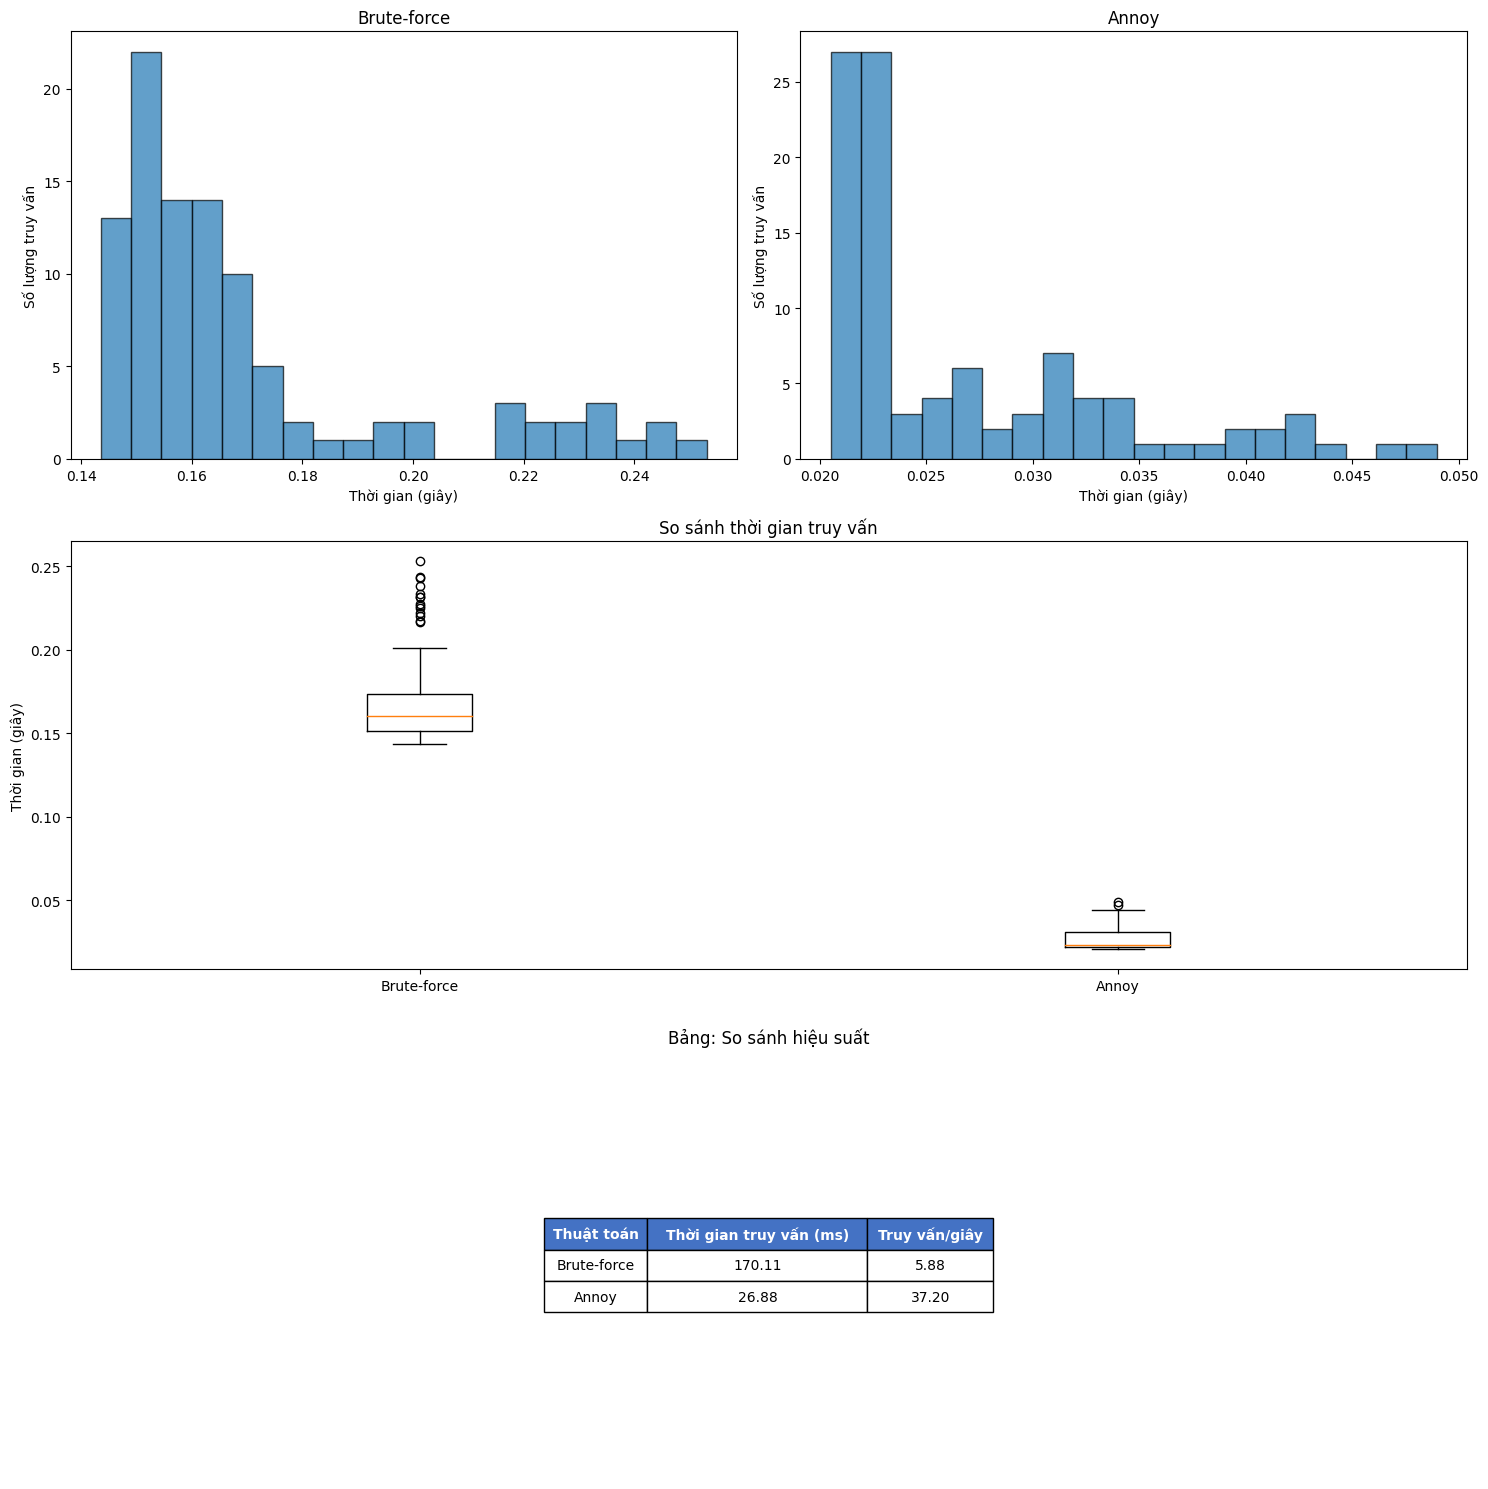

In [ ]:
# Run the performance comparison
bruteforce_times, annoy_times = compare_performance_item_to_user()
plot_performance_comparison(bruteforce_times, annoy_times)